In [1]:
from keras import backend as K  
#K.set_image_dim_ordering('th') 
K.image_data_format() == 'channels_last'
import os
import keras
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
# from PIL import Image
import numpy as np
from keras.models import Sequential
import cv2
import tensorflow as tf
from keras import backend as K
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import GlobalMaxPooling2D, AveragePooling2D, MaxPooling2D, Dropout, GlobalAveragePooling2D, GlobalMaxPool2D
from random import shuffle
from keras.models import load_model
from time import strftime, localtime
from keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# Input Image dimension : 28*28
IMAGE_SIZE = 28

In [3]:
# Control how many threads tensorflow uses.
THREAD_NUM = 1

In [4]:
# Util function to print time.
def printTime():
    tmpTime = localtime()
    print(strftime("%Y-%m-%d %H:%M:%S", tmpTime))
    return tmpTime

In [5]:
def load_test():
    tran_imags = []
    labels = []
    seq_names = ['man', 'woman']
    for seq_name in seq_names:
        frames = sorted(os.listdir(os.path.join(
            './', 'dataset', 'test', seq_name)))
        for frame in frames:
            imgs = [os.path.join('./', 'dataset', 'test', seq_name, frame)]
            img = cv2.imread(imgs[0])

            # Convert to grey scaled image and resize to 28*28
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE), interpolation = cv2.INTER_AREA)
            imgs = np.array(img)
            tran_imags.append(imgs)
            if seq_name == 'man':
                labels.append(0)
            else:
                labels.append(1)
    return np.array(tran_imags), np.array(labels)

In [6]:
def load_train():
    tran_imags = []
    labels = []
    seq_names = ['man', 'woman']
    for seq_name in seq_names:
        frames = sorted(os.listdir(os.path.join(
            './', 'dataset', 'train', seq_name)))
        for frame in frames:
            imgs = [os.path.join('./', 'dataset', 'train', seq_name, frame)]
            img = cv2.imread(imgs[0])
            # Convert to grey scaled image and resize to 28*28
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE), interpolation = cv2.INTER_AREA)
            imgs = np.array(img)
            tran_imags.append(imgs)
            if seq_name == 'man':
                labels.append(0)
            else:
                labels.append(1)
    return tran_imags, labels

In [7]:
def manOrWoman(predictedResult, index):
    if predictedResult[index][0]>predictedResult[index][1]:
        return 'man'
    else:
        return 'woman'

In [8]:
if __name__ == "__main__":

    print('\n\nStart training with %d threads.\n\n' % THREAD_NUM)
    # Initial tensorflow session with indicated threads count.
    with tf.Session(config=tf.ConfigProto( inter_op_parallelism_threads=1, intra_op_parallelism_threads=THREAD_NUM)) as sess:
        K.set_session(sess)
        train_data, train_label = load_train()
        index = []

        # Shuffle data every time to get different train/validate dataset.
        for i in range(1,len(train_data)):
            index.append(i)
        shuffle(index)
        shuffled_train_data =[]
        shuffled_train_label =[]
        for i,v in enumerate(index):
            shuffled_train_data.append(train_data[v])
            shuffled_train_label.append(train_label[v])
        shuffled_train_data = np.array(shuffled_train_data)
        shuffled_train_label = np.array(shuffled_train_label)

        # Construct CNN model
        model = Sequential()
        # Convolutional layer
        model.add(Conv2D(32, (3, 3), activation='relu', padding='same', data_format='channels_last',name='layer1_con1',input_shape=(28,28, 1)))
        model.add(Conv2D(32, (3, 3), activation='relu', padding='same', data_format='channels_last',name='layer1_con2'))
        # Pooling layer
        model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2), padding = 'same', data_format='channels_last',name = 'layer1_pool'))
        # Dropout layer
        model.add(Dropout(0.25))
        # Another coinvolutional layer
        model.add(Conv2D(64, (3, 3), activation='relu', padding='same', data_format='channels_last',name='layer2_con1'))
        model.add(Conv2D(64, (3, 3), activation='relu', padding='same', data_format='channels_last',name='layer2_con2'))
        model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2), padding = 'same', data_format='channels_last',name = 'layer2_pool'))
        # Flatten the matrix
        model.add(Flatten())
        # Dense layer
        model.add(Dense(128, activation='relu'))
        # Another dropout layer
        model.add(Dropout(0.5))
        # Classify into 2 classes.
        model.add(Dense(2, activation='softmax'))
        model.summary()
        # Define parameters
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
        
        # Normalize input
        shuffled_train_data = shuffled_train_data.reshape(shuffled_train_data.shape[0],28,28,1)/255
        print('\n\nStart at ')
        start_time = printTime()
        print("\n")
        
        # Train with 15 epochs, which leads to a nearly converged result. 
        # The validation rate is set to 20% of the total training dataset.
        history = model.fit(shuffled_train_data, keras.utils.to_categorical(
            shuffled_train_label), batch_size=32, epochs=15, verbose=1, shuffle=True,validation_split=0.2)
        
        print('\n\nEnd at ')
        end_time = printTime()
        
        
        # Save the trained model.
        model.save('my_cnn_model.h5')
        loaded_model = load_model('my_cnn_model.h5')
        test_data, test_label = load_test()
        test_data = test_data.reshape(test_data.shape[0],28,28,1)/255
        # Predict the test dataset and summary the value
        result = model.predict(test_data)
        resultStats = [0,0,0,0]
        
        for i,r in enumerate(result):
            print('truth: man' if test_label[i]==0 else 'truth: woman')
            if r[0]>r[1]:
                 print('predicted: man')
            else:
                 print('predicted: woman')




Start training with 1 threads.



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1_con1 (Conv2D)         (None, 28, 28, 32)        320       
_________________________________________________________________
layer1_con2 (Conv2D)         (None, 28, 28, 32)        9248      
_________________________________________________________________
layer1_pool (MaxPooling2D)   (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
layer2_con1 (Conv2D)         (None, 14, 14, 64)        18496     
_________________________________________________________________
layer2_con2 (Conv2D)         (None, 14, 14, 64)        36928     
_________________________________________________________________
layer2_pool (MaxPo

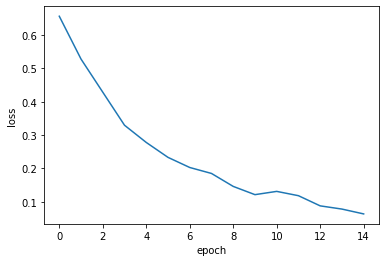

In [9]:
#plot loss
plt.figure()
plt.plot(history.history['loss'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

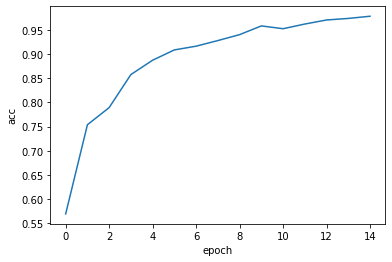

In [10]:
#plot accuracy
plt.plot(history.history['accuracy'])
plt.ylabel("acc")
plt.xlabel("epoch")
plt.show()

In [11]:
for i,r in enumerate(result):
    if(test_label[i]==0):
        if r[0]>r[1]:
            resultStats[0] +=1
        else:
            resultStats[1] +=1
    else:
        if r[0]>r[1]:
            resultStats[2] +=1
        else:
            resultStats[3] +=1

print("test dataset prediction result by CNN:")
print("Man :")
print("\tGround truth: ", resultStats[0]/(resultStats[0]+resultStats[1]))
print("\tFalse positive: ", resultStats[2]/(resultStats[2]+resultStats[3]))

print("Woman :")
print("\tGround truth: ", resultStats[3]/(resultStats[2]+resultStats[3]))
print("\tFalse positive: ", resultStats[1]/(resultStats[0]+resultStats[1]))


test dataset prediction result by CNN:
Man :
	Ground truth:  0.9176470588235294
	False positive:  0.07647058823529412
Woman :
	Ground truth:  0.9235294117647059
	False positive:  0.08235294117647059
